<div>First analytics</div>

In [9]:
import os
from collections import Counter
base_path = 'RespiratoryDatabase@TR/'
items = os.listdir(base_path)
print(items[:20])  # Show first 20 items to see if they're files or directories



['H002_L1.wav', 'H002_L2.wav', 'H002_L3.wav', 'H002_L4.wav', 'H002_L5.wav', 'H002_L6.wav', 'H002_R1.wav', 'H002_R2.wav', 'H002_R3.wav', 'H002_R4.wav', 'H002_R5.wav', 'H002_R6.wav', 'H003_L1.wav', 'H003_L2.wav', 'H003_L3.wav', 'H003_L4.wav', 'H003_L5.wav', 'H003_L6.wav', 'H003_R1.wav', 'H003_R2.wav']


In [ ]:
%pip install librosa matplotlib seaborn pandas numpy scipy openpyxl pydub jupyter notebook 

In [11]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

file_path = 'RespiratoryDatabase@TR/H002_L1.wav'
y, sr = librosa.load(file_path, sr=None)  # y is the audio time series, sr is the sampling rate


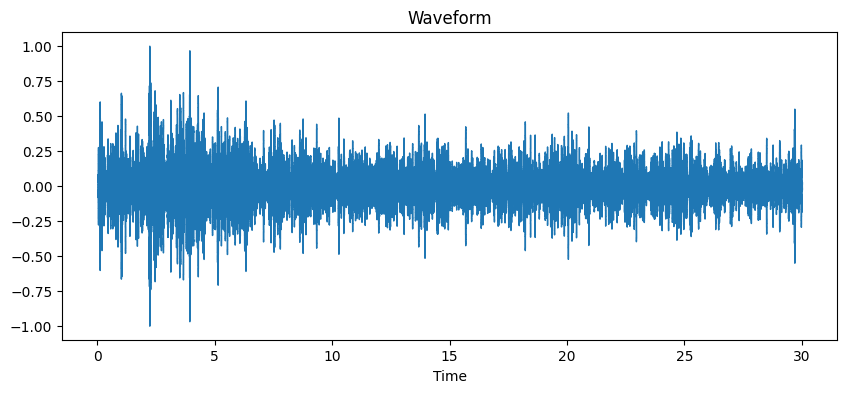

In [12]:
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')
plt.show()


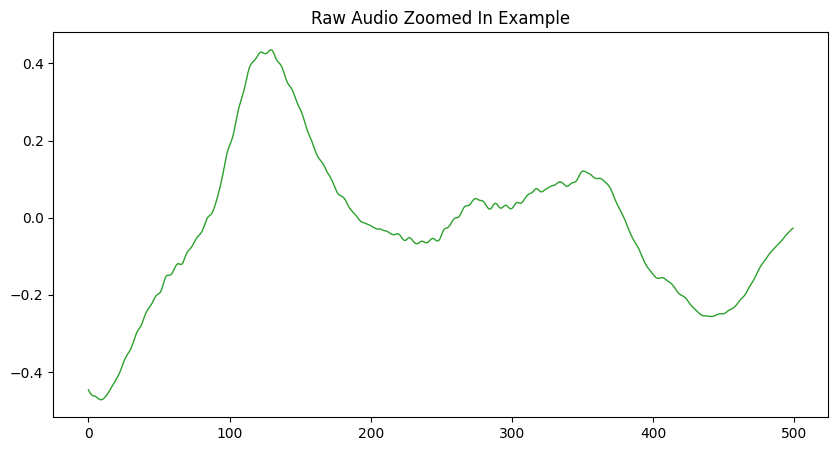

In [13]:
import pandas as pd
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
pd.Series(y[30000:30500]).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Audio Zoomed In Example',
                 color=color_pal[2])
plt.show()

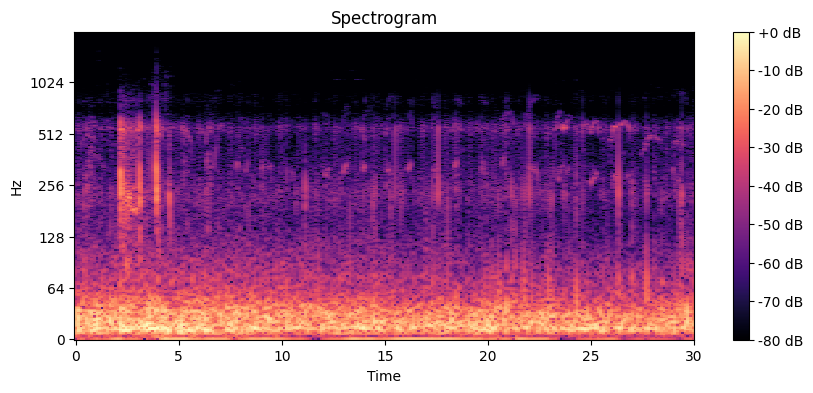

In [14]:
import numpy as np

D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
plt.figure(figsize=(10, 4))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.show()


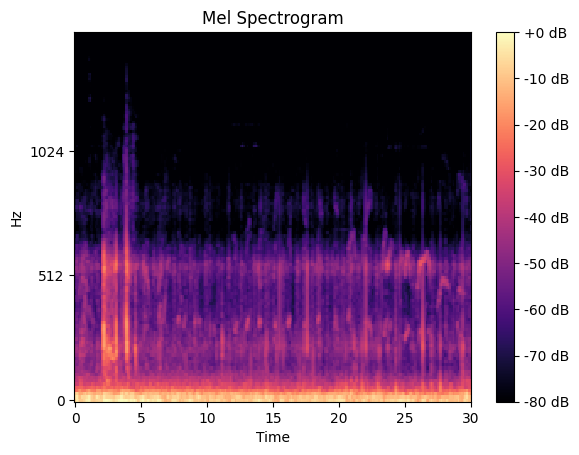

In [15]:
S = librosa.feature.melspectrogram(y=y, sr=sr)
S_DB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis='mel')
plt.title('Mel Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.show()


In [16]:

def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    features = {
        "zcr": np.mean(librosa.feature.zero_crossing_rate(y)),
        "rmse": np.mean(librosa.feature.rms(y=y)),
        "spectral_centroid": np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)),
        "mfcc1": np.mean(librosa.feature.mfcc(y=y, sr=sr)[0]),
        "mfcc2": np.mean(librosa.feature.mfcc(y=y, sr=sr)[1])
    }
    return features

base_path = 'ICBHI_final_database/'
files = [
    f for f in os.listdir(base_path) 
    if os.path.isfile(os.path.join(base_path, f)) and f.endswith('.wav')  # or '.txt'
]

all_data = []

for file in files:
    file_path = os.path.join(base_path, file)
    try:
        feats = extract_features(file_path)
        
        # Example: label is the first 3 digits
        # If your labeling scheme is different, adjust accordingly
        label = file.split('_')[0]
        
        feats["label"] = label
        all_data.append(feats)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        continue

df = pd.DataFrame(all_data)
print(df.head())


        zcr      rmse  spectral_centroid       mfcc1       mfcc2 label
0  0.001192  0.053982         291.511393 -536.597229   80.337196   101
1  0.001184  0.033046         398.452034 -599.051575   81.443336   101
2  0.001393  0.021396         479.680354 -609.898743   95.075272   102
3  0.000636  0.245882         303.540148 -429.030975   59.045887   103
4  0.036546  0.075943         160.261320 -322.799377  193.387131   104


In [ ]:
import seaborn as sns
sns.pairplot(df, hue="label")

In [26]:
import seaborn as sns

base_path = 'RespiratoryDatabase@TR/'
# Assuming your audio files are .wav (adjust if needed)
files = [f for f in os.listdir(base_path) if os.path.isfile(os.path.join(base_path, f)) and f.endswith('.wav')]

data = []  # to store file, duration, and label info
for f in files:
    file_path = os.path.join(base_path, f)
    try:
        y, sr = librosa.load(file_path, sr=None)
        # Calculate audio duration in seconds
        duration = len(y) / sr
        # Extract label from filename (adjust logic according to your naming convention)
        label = f.split('_')[0]
        data.append({'file': f, 'duration': duration, 'label': label})
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

dataFrame = pd.DataFrame(data)
print(dataFrame.head())

          file  duration label
0  H002_L1.wav    30.000  H002
1  H002_L2.wav    18.672  H002
2  H002_L3.wav    18.352  H002
3  H002_L4.wav    24.048  H002
4  H002_L5.wav    19.760  H002


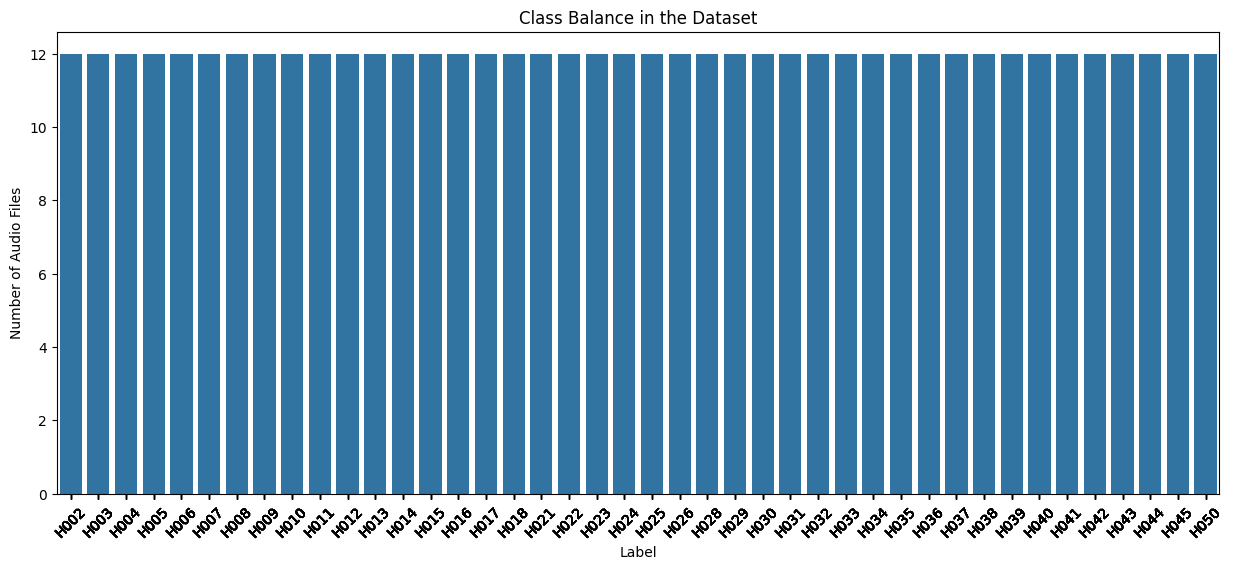

In [ ]:
#Plotting class balance
plt.figure(figsize=(15, 6))
sns.countplot(x='label', data=dataFrame)
plt.title("Class Balance in the Dataset")
# Set x-axis tick labels to show each year below the corresponding bar.
plt.xticks(ticks=dataFrame.label, labels=dataFrame.label, rotation=45)
plt.xlabel("Label")
plt.ylabel("Number of Audio Files")s
plt.show()

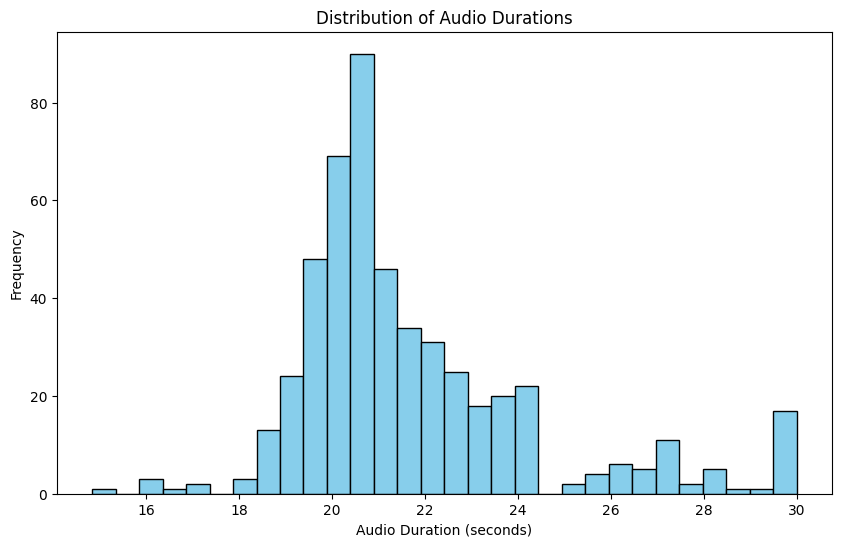

In [33]:
#Examine audio duration
plt.figure(figsize=(10, 6))
plt.hist(dataFrame['duration'], bins=30, edgecolor='black', color='skyblue')
plt.xlabel('Audio Duration (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Audio Durations')
plt.show()


In [34]:
print(dataFrame['duration'].describe())

count    504.000000
mean      21.746032
std        2.652094
min       14.832000
25%       20.144000
50%       20.848000
75%       22.576000
max       30.000000
Name: duration, dtype: float64


In [30]:
mean_duration = dataFrame['duration'].mean()
std_duration = dataFrame['duration'].std()
# Define an outlier as a clip with a duration 2 standard deviations away from the mean
outliers = dataFrame[(dataFrame['duration'] > mean_duration + 2*std_duration) | (dataFrame['duration'] < mean_duration - 2*std_duration)]
print("Outlier files based on duration:", outliers)

Outlier files based on duration:             file  duration label
0    H002_L1.wav    30.000  H002
6    H002_R1.wav    30.000  H002
24   H004_L1.wav    30.000  H004
30   H004_R1.wav    30.000  H004
61   H007_L2.wav    27.440  H007
66   H007_R1.wav    28.336  H007
67   H007_R2.wav    27.184  H007
72   H008_L1.wav    27.376  H008
78   H008_R1.wav    30.000  H008
124  H012_L5.wav    16.240  H012
130  H012_R5.wav    16.368  H012
144  H014_L1.wav    28.080  H014
150  H014_R1.wav    28.080  H014
157  H015_L2.wav    28.144  H015
158  H015_L3.wav    29.424  H015
159  H015_L4.wav    30.000  H015
164  H015_R3.wav    28.976  H015
165  H015_R4.wav    30.000  H015
166  H015_R5.wav    30.000  H015
265  H026_L2.wav    30.000  H026
267  H026_L4.wav    14.832  H026
268  H026_L5.wav    30.000  H026
269  H026_L6.wav    30.000  H026
271  H026_R2.wav    30.000  H026
274  H026_R5.wav    30.000  H026
275  H026_R6.wav    28.464  H026
288  H029_L1.wav    27.248  H029
294  H029_R1.wav    27.184  H029
328  H032_

#Diagnosis

In [37]:
%pip install openpyxl

     -------------------------------------- 250.9/250.9 kB 2.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [38]:
data = pd.read_excel("COPD.xlsx", engine='openpyxl')
data.head()

,Patient ID,Diagnosis
0,H002,COPD4
1,H003,COPD4
2,H004,COPD4
3,H005,COPD4
4,H006,COPD4


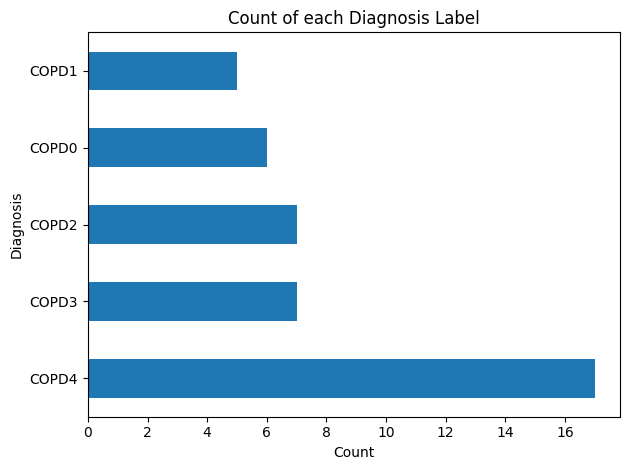

In [ ]:
# Basic vertical bar chart
counts = data['Diagnosis'].value_counts()

# Step 3: Plot horizontal bar chart
fig, ax = plt.subplots()
counts.plot(kind='barh', ax=ax)
ax.set_title('Count of each Diagnosis Label')
ax.set_xlabel('Count')
ax.set_ylabel('Diagnosis')
plt.tight_layout()
plt.show()

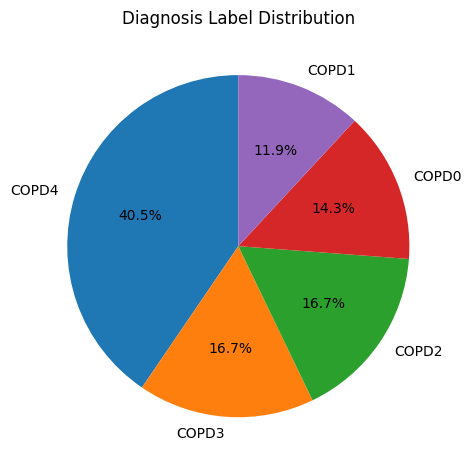

In [ ]:
fig, ax = plt.subplots()
counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, ax=ax)
ax.set_ylabel('')
ax.set_title('Diagnosis Label Distribution')
plt.tight_layout()
plt.show()